### Árbol de Decisión para Regresión
#### Este notebook implementa un modelo de Árbol de Decisión para predecir la popularidad de canciones de Spotify.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
import warnings
warnings.filterwarnings('ignore')

print("✅ Librerías importadas correctamente")


✅ Librerías importadas correctamente


In [ ]:
# Cargar datasets con feature engineering aplicado
train = pd.read_csv("../data/train_fe.csv")
test = pd.read_csv("../data/test_fe.csv")

print(f"Train shape: {train.shape}")
print(f"Test shape: {test.shape}")
print(f"\nColumnas en train: {train.columns.tolist()}")

Train shape: (79800, 17)
Test shape: (34200, 16)

Columnas en train: ['track_id', 'popularity', 'explicit', 'danceability', 'energy', 'loudness', 'speechiness', 'instrumentalness', 'valence', 'tempo', 'time_signature', 'artist_count', 'album_mean_popularity', 'track_name_len', 'track_has_remix', 'track_has_acoustic', 'genre_mean_popularity']


In [ ]:
# Separar features y target
X_train = train.drop(columns=['track_id', 'popularity'])
y_train = train['popularity']

X_test = test.drop(columns=['track_id'])

In [4]:
# Verificar si hay valores nulos
print(f"Valores nulos en X_train: {X_train.isnull().sum().sum()}")
print(f"Valores nulos en y_train: {y_train.isnull().sum()}")
print(f"Valores nulos en X_test: {X_test.isnull().sum().sum()}")

print(f"\nShape X_train: {X_train.shape}")
print(f"Shape y_train: {y_train.shape}")
print(f"Shape X_test: {X_test.shape}")

Valores nulos en X_train: 0
Valores nulos en y_train: 0
Valores nulos en X_test: 0

Shape X_train: (79800, 15)
Shape y_train: (79800,)
Shape X_test: (34200, 15)


### Modelo Base - Árbol de Decisión sin tunear
#### Primero entrenaremos un modelo base con parámetros por defecto para establecer un baseline.

In [5]:
# Entrenar modelo base con parámetros por defecto
dt_base = DecisionTreeRegressor(random_state=42)
dt_base.fit(X_train, y_train)

# Predicciones en train
y_train_pred_base = dt_base.predict(X_train)

# Métricas en train
mse_train_base = mean_squared_error(y_train, y_train_pred_base)
rmse_train_base = np.sqrt(mse_train_base)
mae_train_base = mean_absolute_error(y_train, y_train_pred_base)
r2_train_base = r2_score(y_train, y_train_pred_base)

print("=" * 60)
print("MODELO BASE - Métricas en TRAIN")
print("=" * 60)
print(f"MSE:  {mse_train_base:.4f}")
print(f"RMSE: {rmse_train_base:.4f}")
print(f"MAE:  {mae_train_base:.4f}")
print(f"R²:   {r2_train_base:.4f}")
print(f"\nProfundidad del árbol: {dt_base.get_depth()}")
print(f"Número de hojas: {dt_base.get_n_leaves()}")

MODELO BASE - Métricas en TRAIN
MSE:  0.1003
RMSE: 0.3168
MAE:  0.0102
R²:   0.9998

Profundidad del árbol: 44
Número de hojas: 33804


In [17]:
# Validación cruzada para evaluar generalización
cv_scores_base = cross_val_score(dt_base, X_train, y_train, 
                                  cv=5, 
                                  scoring='neg_mean_squared_error')

rmse_cv_base = np.sqrt(-cv_scores_base)

print("=" * 60)
print("MODELO BASE - Validación Cruzada (5-fold)")
print("=" * 60)
print(f"RMSE por fold: {rmse_cv_base}")
print(f"RMSE medio: {rmse_cv_base.mean():.4f} (+/- {rmse_cv_base.std():.4f})")

MODELO BASE - Validación Cruzada (5-fold)
RMSE por fold: [8.07898819 8.15417021 7.94902206 8.08575107 7.89468687]
RMSE medio: 8.0325 (+/- 0.0957)


In [7]:
# ## Optimización de Hiperparámetros con GridSearchCV
# Vamos a tunear los siguientes hiperparámetros:
# - **max_depth**: Profundidad máxima del árbol
# - **min_samples_split**: Mínimo de muestras para dividir un nodo
# - **min_samples_leaf**: Mínimo de muestras en una hoja
# - **max_features**: Número de features a considerar en cada split

# Cell 9: GridSearchCV
# Definir grilla de hiperparámetros
param_grid = {
    'max_depth': [5, 10, 15, 20, 25, None],
    'min_samples_split': [2, 10, 20, 50],
    'min_samples_leaf': [1, 5, 10, 20],
    'max_features': ['sqrt', 'log2', None]
}

print("Iniciando búsqueda de hiperparámetros...")
print(f"Combinaciones a probar: {len(param_grid['max_depth']) * len(param_grid['min_samples_split']) * len(param_grid['min_samples_leaf']) * len(param_grid['max_features'])}")

Iniciando búsqueda de hiperparámetros...
Combinaciones a probar: 288


In [8]:
# GridSearchCV con validación cruzada
grid_search = GridSearchCV(
    estimator=DecisionTreeRegressor(random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

print("\n✅ Búsqueda completada")
print(f"\nMejores hiperparámetros encontrados:")
for param, value in grid_search.best_params_.items():
    print(f"  {param}: {value}")

print(f"\nMejor RMSE en CV: {np.sqrt(-grid_search.best_score_):.4f}")

Fitting 5 folds for each of 288 candidates, totalling 1440 fits

✅ Búsqueda completada

Mejores hiperparámetros encontrados:
  max_depth: 20
  max_features: None
  min_samples_leaf: 10
  min_samples_split: 50

Mejor RMSE en CV: 6.7290


In [9]:
# Obtener el mejor modelo
dt_optimized = grid_search.best_estimator_

# Predicciones en train
y_train_pred_opt = dt_optimized.predict(X_train)

# Métricas en train
mse_train_opt = mean_squared_error(y_train, y_train_pred_opt)
rmse_train_opt = np.sqrt(mse_train_opt)
mae_train_opt = mean_absolute_error(y_train, y_train_pred_opt)
r2_train_opt = r2_score(y_train, y_train_pred_opt)

print("=" * 60)
print("MODELO OPTIMIZADO - Métricas en TRAIN")
print("=" * 60)
print(f"MSE:  {mse_train_opt:.4f}")
print(f"RMSE: {rmse_train_opt:.4f}")
print(f"MAE:  {mae_train_opt:.4f}")
print(f"R²:   {r2_train_opt:.4f}")
print(f"\nProfundidad del árbol: {dt_optimized.get_depth()}")
print(f"Número de hojas: {dt_optimized.get_n_leaves()}")

MODELO OPTIMIZADO - Métricas en TRAIN
MSE:  30.6779
RMSE: 5.5388
MAE:  2.9946
R²:   0.9385

Profundidad del árbol: 20
Número de hojas: 2246


In [10]:
# Comparar modelo base vs optimizado
comparison_df = pd.DataFrame({
    'Modelo': ['Base (sin tunear)', 'Optimizado (GridSearchCV)'],
    'RMSE Train': [rmse_train_base, rmse_train_opt],
    'RMSE CV': [rmse_cv_base.mean(), np.sqrt(-grid_search.best_score_)],
    'R² Train': [r2_train_base, r2_train_opt],
    'Profundidad': [dt_base.get_depth(), dt_optimized.get_depth()],
    'Número de Hojas': [dt_base.get_n_leaves(), dt_optimized.get_n_leaves()]
})

print("\n" + "=" * 80)
print("COMPARACIÓN DE MODELOS")
print("=" * 80)
print(comparison_df.to_string(index=False))
print("\n✅ El modelo optimizado tiene mejor generalización (menor diferencia Train-CV)")


COMPARACIÓN DE MODELOS
                   Modelo  RMSE Train  RMSE CV  R² Train  Profundidad  Número de Hojas
        Base (sin tunear)    0.316772 8.032524  0.999799           44            33804
Optimizado (GridSearchCV)    5.538765 6.728962  0.938479           20             2246

✅ El modelo optimizado tiene mejor generalización (menor diferencia Train-CV)



Top 10 Features más importantes:
              feature  importance
album_mean_popularity    0.935826
genre_mean_popularity    0.033495
         artist_count    0.012625
     instrumentalness    0.004464
             loudness    0.002388
         danceability    0.002327
              valence    0.002240
               energy    0.001848
          speechiness    0.001628
       track_name_len    0.001477


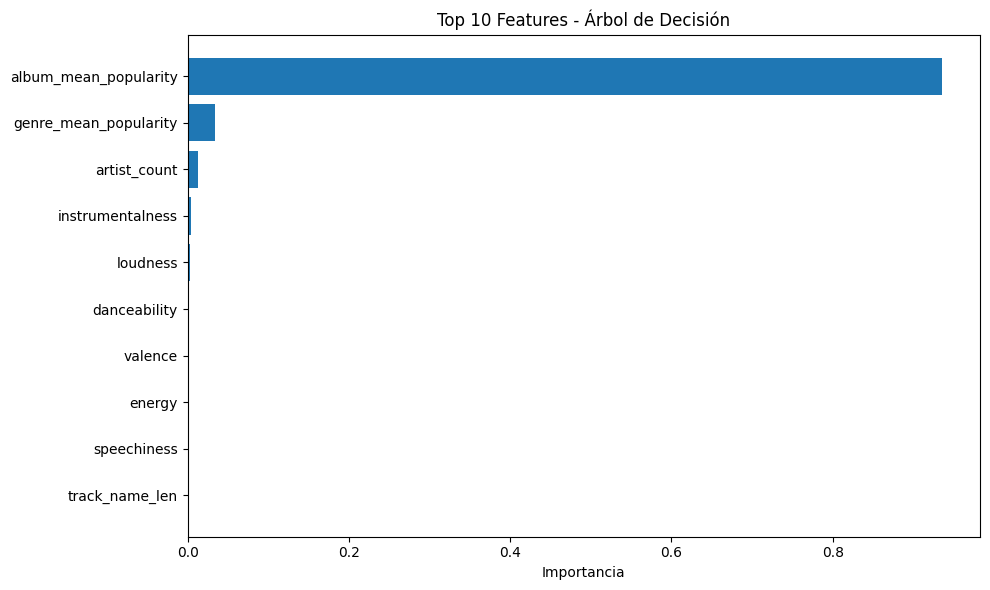

In [11]:
# Obtener importancia de features
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': dt_optimized.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 10 Features más importantes:")
print(feature_importance.head(10).to_string(index=False))

# Visualizar
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['feature'].head(10), 
         feature_importance['importance'].head(10))
plt.xlabel('Importancia')
plt.title('Top 10 Features - Árbol de Decisión')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

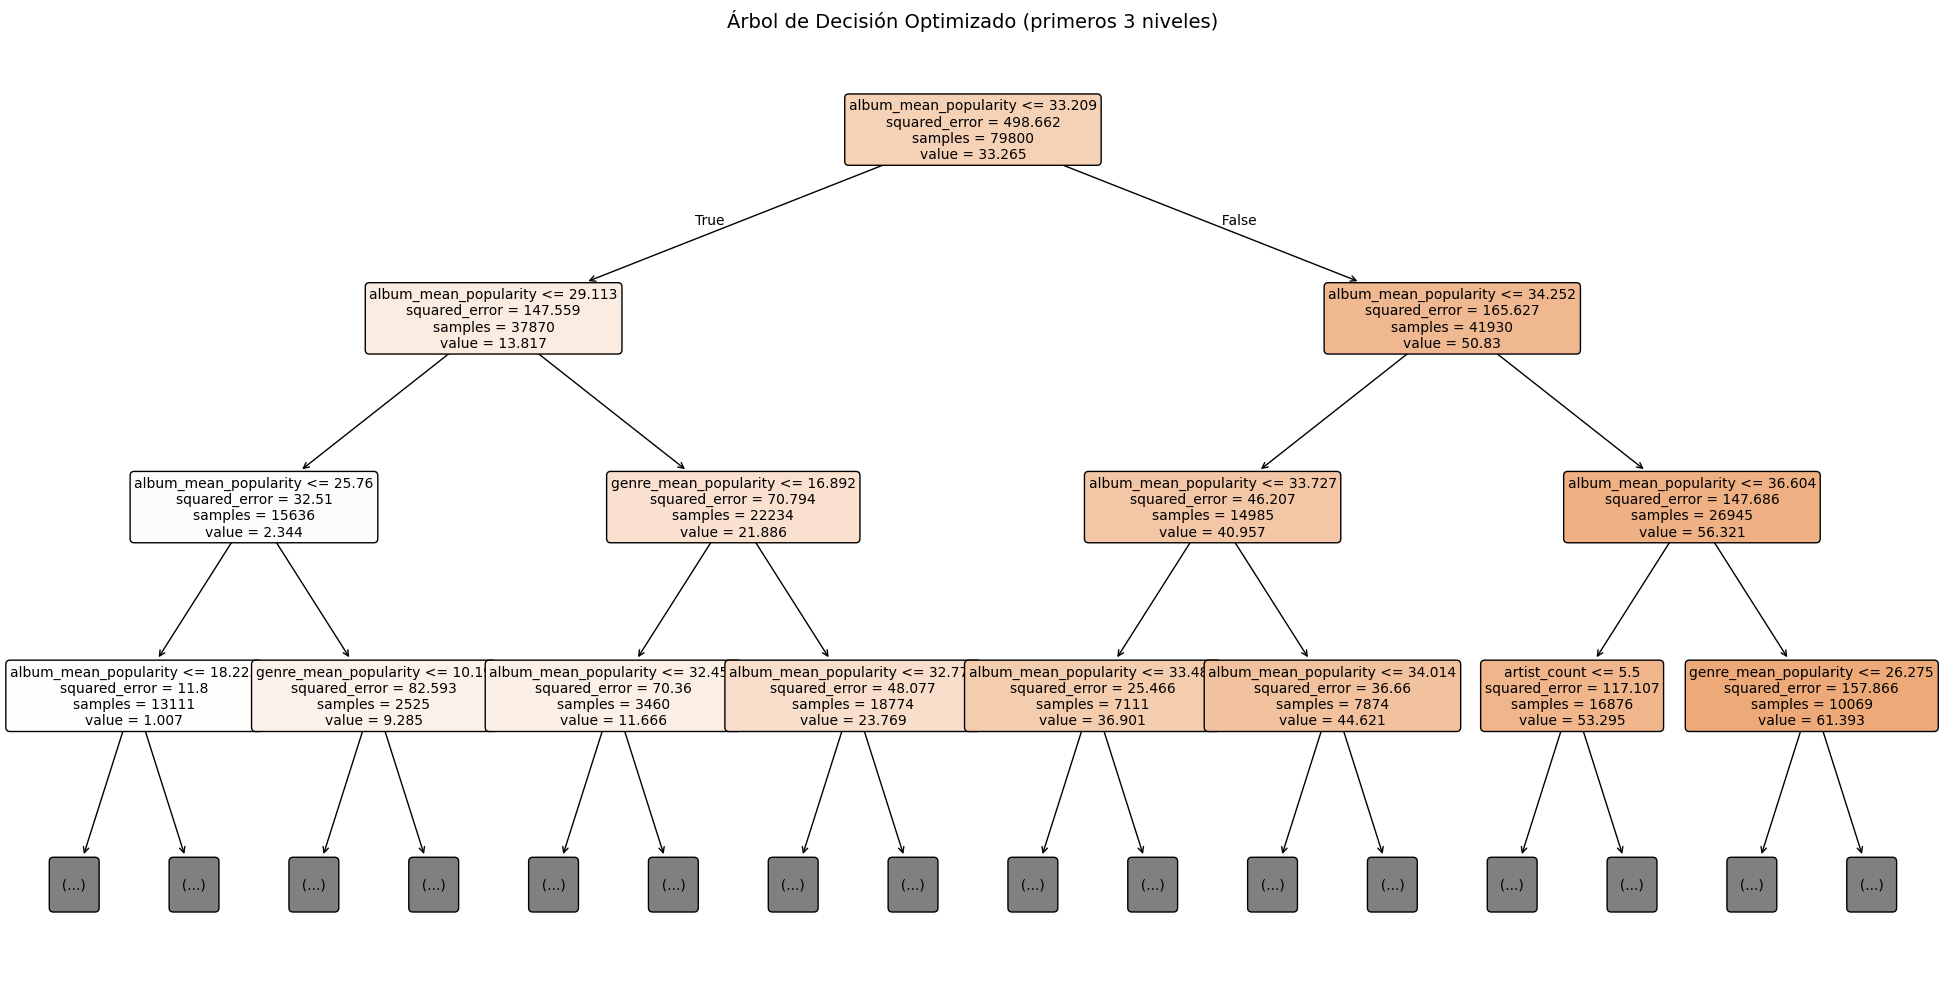

In [12]:
# Visualizar los primeros 3 niveles del árbol optimizado
plt.figure(figsize=(20, 10))
plot_tree(dt_optimized, 
          max_depth=3,
          feature_names=X_train.columns,
          filled=True,
          fontsize=10,
          rounded=True)
plt.title('Árbol de Decisión Optimizado (primeros 3 niveles)', fontsize=14)
plt.tight_layout()
plt.show()

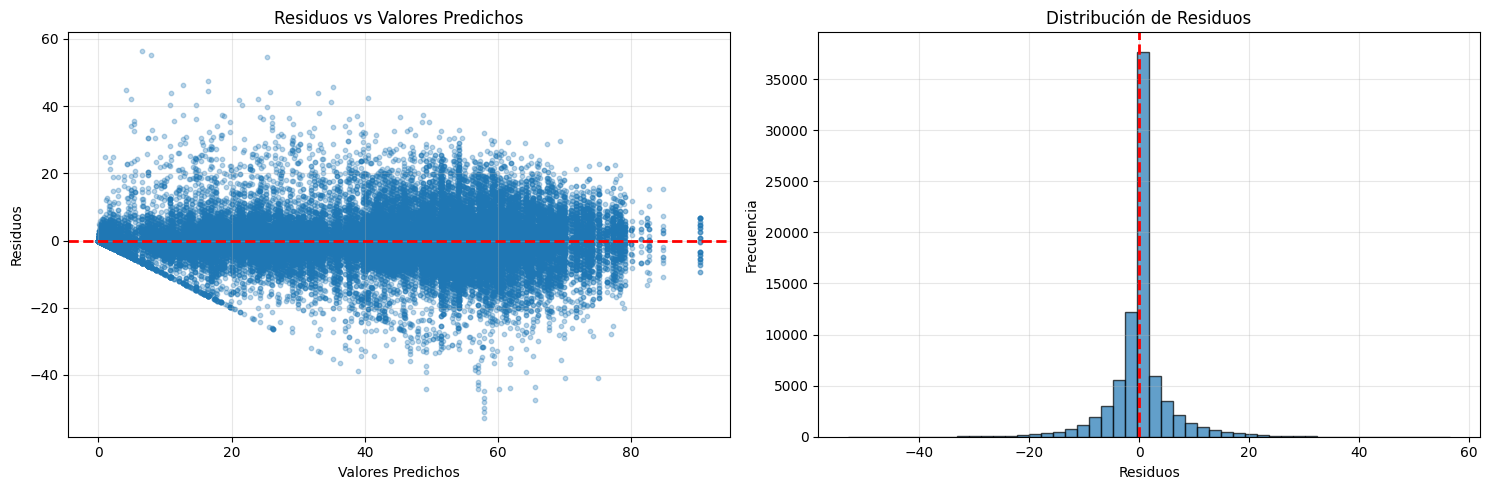

Media de residuos: -0.0000
Desviación estándar de residuos: 5.5388


In [13]:
# Calcular residuos
residuals = y_train - y_train_pred_opt

# Gráfico de residuos
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Residuos vs valores predichos
axes[0].scatter(y_train_pred_opt, residuals, alpha=0.3, s=10)
axes[0].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[0].set_xlabel('Valores Predichos')
axes[0].set_ylabel('Residuos')
axes[0].set_title('Residuos vs Valores Predichos')
axes[0].grid(True, alpha=0.3)

# Histograma de residuos
axes[1].hist(residuals, bins=50, edgecolor='black', alpha=0.7)
axes[1].axvline(x=0, color='r', linestyle='--', linewidth=2)
axes[1].set_xlabel('Residuos')
axes[1].set_ylabel('Frecuencia')
axes[1].set_title('Distribución de Residuos')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Media de residuos: {residuals.mean():.4f}")
print(f"Desviación estándar de residuos: {residuals.std():.4f}")

In [14]:
# Generar predicciones para el conjunto de test
y_test_pred = dt_optimized.predict(X_test)

# Crear DataFrame con predicciones
predictions_df = pd.DataFrame({
    'track_id': test['track_id'],
    'popularity_predicha': y_test_pred
})

print("Predicciones en TEST:")
print(predictions_df.head(10))
print(f"\nEstadísticas de predicciones:")
print(predictions_df['popularity_predicha'].describe())

# Guardar predicciones
predictions_df.to_csv('../data/predictions_decision_tree.csv', index=False)
print("\n✅ Predicciones guardadas en: ../data/predictions_decision_tree.csv")

Predicciones en TEST:
                 track_id  popularity_predicha
0  6KwkVtXm8OUp2XffN5k7lY            47.558824
1  2dp5I5MJ8bQQHDoFaNRFtX            13.687861
2  5avw06usmFkFrPjX8NxC40             0.000000
3  75hT0hvlESnDJstem0JgyR             0.012658
4  4bY2oZGA5Br3pTE1Jd1IfY            28.352941
5  2zQt5C0AIv27RhfJCRZdZ4            39.673469
6  6BctgCJXlgxYeR0ObhLdtR            33.125000
7  1LDQFdGTEXOnycDC8CJ5p1            32.574468
8  2DDR5F7bHFJBiX6lPPsT8O            38.000000
9  2ScU6iEvgb0TIuKiyem9rg            51.225806

Estadísticas de predicciones:
count    34200.000000
mean        31.274964
std         19.216416
min          0.000000
25%         20.181818
50%         32.992481
75%         43.000000
max         90.340909
Name: popularity_predicha, dtype: float64

✅ Predicciones guardadas en: ../data/predictions_decision_tree.csv


In [16]:
#Resumen final:

print("\n" + "=" * 80)
print("RESUMEN FINAL - ÁRBOL DE DECISIÓN PARA REGRESIÓN")
print("=" * 80)
print(f"\n DATASET:")
print(f"   - Muestras de entrenamiento: {len(X_train):,}")
print(f"   - Muestras de test: {len(X_test):,}")
print(f"   - Número de features: {X_train.shape[1]}")

print(f"\n MODELO OPTIMIZADO:")
print(f"   - max_depth: {dt_optimized.max_depth}")
print(f"   - min_samples_split: {dt_optimized.min_samples_split}")
print(f"   - min_samples_leaf: {dt_optimized.min_samples_leaf}")
print(f"   - max_features: {dt_optimized.max_features}")
print(f"   - Profundidad real: {dt_optimized.get_depth()}")
print(f"   - Número de hojas: {dt_optimized.get_n_leaves()}")

print(f"\n MÉTRICAS EN TRAIN:")
print(f"   - RMSE: {rmse_train_opt:.4f}")
print(f"   - MAE:  {mae_train_opt:.4f}")
print(f"   - R²:   {r2_train_opt:.4f}")

print(f"\n VALIDACIÓN CRUZADA (5-fold):")
print(f"   - RMSE: {np.sqrt(-grid_search.best_score_):.4f}")

print(f"\n TOP 3 FEATURES:")
for idx, row in feature_importance.head(3).iterrows():
    print(f"   {idx+1}. {row['feature']}: {row['importance']:.4f}")

print("\n" + "=" * 80)


RESUMEN FINAL - ÁRBOL DE DECISIÓN PARA REGRESIÓN

 DATASET:
   - Muestras de entrenamiento: 79,800
   - Muestras de test: 34,200
   - Número de features: 15

 MODELO OPTIMIZADO:
   - max_depth: 20
   - min_samples_split: 50
   - min_samples_leaf: 10
   - max_features: None
   - Profundidad real: 20
   - Número de hojas: 2246

 MÉTRICAS EN TRAIN:
   - RMSE: 5.5388
   - MAE:  2.9946
   - R²:   0.9385

 VALIDACIÓN CRUZADA (5-fold):
   - RMSE: 6.7290

 TOP 3 FEATURES:
   11. album_mean_popularity: 0.9358
   15. genre_mean_popularity: 0.0335
   10. artist_count: 0.0126

